In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import squarify

from functions import run_proportional_scaling
from helpers import fetch_area_data, get_variables
from tree import build_tree, fetch_branch, fetch_values_given_key, get_subindustries_data
from config import settings

In [2]:
print('51163 Rockbridge County, Virginia')
df, url = fetch_area_data('2021',4,'51163')

51163 Rockbridge County, Virginia


In [3]:
# https://www.bls.gov/cew/classifications/aggregation/agg-level-titles.htm
total_establishments = int(df[df['agglvl_code']==70][settings.establishments])
print(f"Total establishments in the county: {total_establishments}") 
aggregations = range(74,78+1)
for aggregation in aggregations:
    print(f"The sum of establishment counts at level {aggregation}: {np.sum(df[df['agglvl_code']==aggregation][settings.establishments])}")

Total establishments in the county: 542
The sum of establishment counts at level 74: 542
The sum of establishment counts at level 75: 542
The sum of establishment counts at level 76: 542
The sum of establishment counts at level 77: 542
The sum of establishment counts at level 78: 542


In [4]:
# cast data into a tree structure with nested mappings
# county = {'ind': 10, 'est': 533, 'emp': 5937, children': [{}, {}, ...]}
county = build_tree(df, '10', 71)

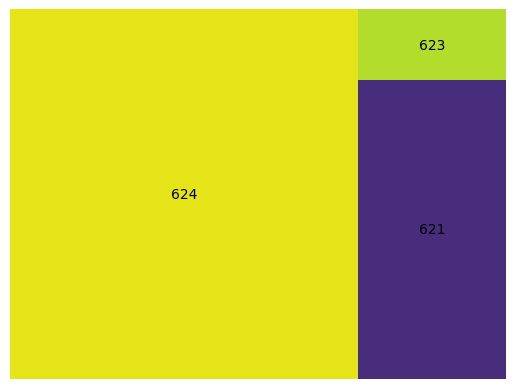

In [5]:
# Return industry details
industry = fetch_branch(county, 'ind', '62')
sub_industries = [sub_industry['ind'] for sub_industry in industry['children']]
est = [sub_industry['est'] for sub_industry in industry['children']]

sub_industries_sorted = [ind for _, ind in sorted(zip(est, sub_industries), reverse=True)]
est_sorted = sorted(est, reverse=True)
squarify.plot(sizes=est_sorted, label=sub_industries_sorted)
plt.axis('off')
plt.show()

In [6]:
# Proportional scaling example
industry = fetch_branch(county, 'ind', '10')
print('*** overall number of establishments ***')
print(industry['est'])
print('*** overall employment ***')
print(industry['emp'])
print('*** sub industries ***')
print([sub_industry['ind'] for sub_industry in industry['children']])
print('*** number of establishments in the sub industries ***')
print([sub_industry['est'] for sub_industry in industry['children']])
print('*** employment in the sub industries ***')
print([sub_industry['emp'] for sub_industry in industry['children']])
print('*** employment approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
employment = np.array([sub_industry['emp'] for sub_industry in industry['children']],dtype = object)
employment_ps = employment.copy()
undisclosed_est = np.sum(establishments[np.where(employment==0)])
undisclosed_emp = industry['emp'] - np.sum(employment)
employment_ps[np.where(employment==0)] = establishments[np.where(employment==0)]/undisclosed_est*undisclosed_emp
print(employment_ps)
print('*** wages in the sub industries ***')
print([sub_industry['wages'] for sub_industry in industry['children']])
print('*** wages approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
wages = np.array([sub_industry['wages'] for sub_industry in industry['children']],dtype = object)
wages_ps = wages.copy()
undisclosed_est = np.sum(establishments[np.where(wages==0)])
undisclosed_wages = industry['wages'] - np.sum(wages)
wages_ps[np.where(wages==0)] = establishments[np.where(wages==0)]/undisclosed_est*undisclosed_wages
print(wages_ps)



*** overall number of establishments ***
512
*** overall employment ***
4752
*** sub industries ***
['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '99']
*** number of establishments in the sub industries ***
[17, 1, 2, 74, 25, 13, 62, 17, 9, 18, 9, 33, 2, 26, 5, 87, 13, 46, 41, 12]
*** employment in the sub industries ***
[0, 0, 0, 369, 897, 0, 1196, 77, 29, 106, 18, 0, 0, 0, 69, 507, 112, 584, 148, 17]
*** employment approximation proportional scaling ***
[112.67021276595746 6.627659574468085 13.25531914893617 369 897
 86.15957446808511 1196 77 29 106 18 218.7127659574468 13.25531914893617
 172.31914893617022 69 507 112 584 148 17]
*** wages in the sub industries ***
[0, 0, 0, 5804030, 10083092, 0, 9508668, 1079078, 400983, 1485148, 279793, 0, 0, 0, 683429, 5824644, 1057960, 3722327, 1286572, 142041]
*** wages approximation proportional scaling ***
[1471543.510638298 86561.3829787234 173122.7659574468 5804030

In [7]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = employment,
        name = 'employment'
    )
)
fig.add_trace(
    go.Bar(
        y = employment_ps,
        name = 'employment ps'
    )
)
fig.update_layout(
    title='Employment and employment approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [8]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = wages,
        name = 'wages'
    )
)
fig.add_trace(
    go.Bar(
        y = wages_ps,
        name = 'wages ps'
    )
)
fig.update_layout(
    title='Wages and wages approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [9]:
# proportional scaling & saving the data into the same tree
industry = fetch_branch(county, 'ind', '10')
data = get_subindustries_data(industry)
county = run_proportional_scaling(county, industry, data)

In [10]:
# loop through the entire tree
for ind in fetch_values_given_key(county, 'ind', []):
    industry = fetch_branch(county, 'ind', ind)
    data = get_subindustries_data(industry)
    county = run_proportional_scaling(county, industry, data)

In [11]:
for ind in fetch_values_given_key(county, 'ind', []):
    print(f'*** {ind} *** ')
    industry = fetch_branch(county, 'ind', ind)
    print(industry['emp'])
    if industry.get('emp_ps') is not None:
        print(industry['emp_ps'])

*** 10 *** 
4752
*** 11 *** 
0
112.67021276595744
*** 111 *** 
0
21.55673758865248
*** 1119 *** 
0
21.55673758865248
*** 11199 *** 
0
21.55673758865248
*** 111998 *** 
0
21.55673758865248
*** 112 *** 
35
*** 1121 *** 
0
27.22222222222222
*** 11211 *** 
0
19.444444444444446
*** 112111 *** 
0
19.444444444444446
*** 11212 *** 
0
7.777777777777778
*** 112120 *** 
0
7.777777777777778
*** 1129 *** 
0
7.777777777777778
*** 11292 *** 
0
3.888888888888889
*** 112920 *** 
0
3.888888888888889
*** 11299 *** 
0
3.888888888888889
*** 112990 *** 
0
3.888888888888889
*** 113 *** 
13
*** 1132 *** 
0
2.6
*** 11321 *** 
0
2.6
*** 113210 *** 
0
2.6
*** 1133 *** 
0
10.4
*** 11331 *** 
0
10.4
*** 113310 *** 
0
10.4
*** 115 *** 
0
43.11347517730496
*** 1151 *** 
0
21.55673758865248
*** 11511 *** 
0
21.55673758865248
*** 115115 *** 
0
21.55673758865248
*** 1152 *** 
0
21.55673758865248
*** 11521 *** 
0
21.55673758865248
*** 115210 *** 
0
21.55673758865248
*** 21 *** 
0
6.627659574468085
*** 212 *** 
0
6.62765

In [31]:
industry = fetch_branch(county, 'ind', '5222')
print(industry['est'])
print(industry['emp'])
if industry.get('emp_ps') is not None:
    print(industry['emp_ps'])
for child in industry['children']:
    print(f"ind {child['ind']}")
    print(child['est'])
    print(child['emp'])
    if child.get('emp_ps') is not None:
        print(child['emp_ps'])


2
0
16.181818181818183
ind 52229
2
0
16.181818181818183


In [13]:
# download all 6 digit codes